# Base Imports :
*   Import our dependencies
*   Initialize session and make sure tensorflow doesn't hog all of the gpu for itself by setting the allow growth config




In [6]:
# Base Imports 
import json
import pandas as pd
from pprint import pprint
import argparse
import io
import re
import os
from os import listdir
from os.path import isfile, join
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import webbrowser
# Initialize session and make sure tensorflow doesn't hog all of the gpu for itself by setting the allow growth config
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

# Elmo Embedding:
* Creating a method that loads the Elmo Embedding into our model

[note: Look into Bert or XLnet as potential replacements for Elmo]

In [2]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)


In [15]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.reshape(K.cast(x, tf.string), [-1]), signature="default", as_dict=True)["elmo"]
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], None, self.dimensions)

# Method() for building the model skeleton:
* The model architecture is defined and the weights are initialized here
*  Change pred layer to add or remove more classes (currently set to differentiate between 19 classes)


In [16]:
# Function to build model
# Can be tweaked based on size of dataset to prevent overfitting
def build_model(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  embedding = embedding+coord
  print(embedding.shape)
  BiLSTM = layers.Bidirectional(layers.LSTM(512, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding)
  dense1 = layers.Dense(512, activation='relu')(BiLSTM)
  
  dense2 = layers.Dense(256,activation="relu")(dense1)
  pred = layers.Dense(19, activation='softmax')(dense2)

  model = Model(inputs=[input_text], outputs=pred)
#   model = multi_gpu_model(base_model, gpus=4)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return(model)

In [17]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(?, ?, 1024)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_5 (Elmo (None, None, 1024)        4         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 1024)              6295552   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 19)                4883      
Total params: 6,956,567
Trainable params: 6,956,567
Non-trainable params: 0
____________________________________

## Use the following code to load a pre-trained model directly into our model skeleton:

```
model=load_model("halfnonehalfsac.h5", custom_objects={'ElmoEmbeddingLayer': ElmoEmbeddingLayer()})
```



# Loading our  <u>*Labelled*</u> Dataset as a pandas dataframe:
## Tips for labelling:
* While labelling the dataset it is important preserve the input format of the ocr generated text Blocks .i.e They should not be automatically formatted(by excel)
* (Recommended): Create a simple GUI to label faster.
* (Alternative): if excel is used for labelling, refer to the following link to stop excel from autoformatting the dataset
* https://help.aftership.com/hc/en-us/articles/115008353147-How-to-correctly-import-open-a-CSV-file-in-Excel-



In [26]:
#everything we've labelled so far
df=pd.read_csv('C:\\Users\\sayee\\Python-ML(Udemy)\\NLP Research Paper\\Invoice_data_extraction\\labelled dataset\\SuperDuperClean6167dataset.csv')
#Extra data extracted from the excel files given to us
df1=pd.read_csv('C:\\Users\\sayee\\Python-ML(Udemy)\\NLP Research Paper\\Invoice_data_extraction\\labelled dataset\\extradataset.csv')
df=df.append(df1, ignore_index=True)

## The more balanced the counts of the different classes are the better:
* under representation is fine but over representation(example: none) should be avoided.

In [31]:
pd.Series(df.label).value_counts()

none                 718
address              701
date                 551
amount               370
intents_VendorGST    364
vendor_name          361
sac                  326
description          245
total_amount         203
ph_no                143
quantity             107
tax_amount            99
tot_in_words          95
intents_OrgGST        73
tax_percent           71
email                 62
pan                   48
bill_period           31
cin                   27
Name: label, dtype: int64

In [30]:
#for removing half the none blocks
#run this twice for nones alone
j=0
for index, row in df.iterrows():
    if(row['label']=='sac'):
        j=j+1
        if j%2==0:
            #print(j)
            df.drop(index, inplace=True)

In [22]:
df

,Blocks,label,Source
0,GST NO. 37AADCV9696D2ZQ,intents_VendorGST,219143549.pdf
1,t'ul Mag Gemoval,none,219143549.pdf
2,VASHANTH OUTDOOR MEDIA PVT. LTD.,vendor_name,219143549.pdf
3,"· H.0: # 517, Industrial Estate, Renigunta Roa...",address,219143549.pdf
4,"B.O : # 8/79/2, Joythi Enclaves, 2nd Floor, Op...",address,219143549.pdf
...,...,...,...
7067,32AABCB5576G5ZQ,intents_VendorGST,excel_file
7068,GSTIN/UIN: 27AAHCR5539F1Z6,intents_VendorGST,excel_file
7069,GST No: . *32AACFN1353M1ZF,intents_VendorGST,excel_file
7070,GST Number: 29AAJCS2290L1ZS,intents_VendorGST,excel_file


# Preprocessing the dataframe to make it suitable for the ElmoEmbedding:
* get_dummies function takes a single column and performs one-hot encoding on it.
* Through experimentation it was found that converting everything to lowercase before training(or predicting) *generally* works better.

In [32]:
tempdf1=df
traindf=pd.get_dummies(df,columns=['label'])
traindf=traindf.drop(['Source'],axis=1)
traindf['Blocks']=traindf['Blocks'].str.lower()
traindf.sample(5)

,Blocks,label_address,label_amount,label_bill_period,label_cin,label_date,label_description,label_email,label_intents_OrgGST,label_intents_VendorGST,label_none,label_pan,label_ph_no,label_quantity,label_sac,label_tax_amount,label_tax_percent,label_tot_in_words,label_total_amount,label_vendor_name
4894,matri,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3244,"igst - rs. 1, 32, 975/.chq. no:...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3816,1.0tr,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4160,pan no : aauph1878d,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1809,12.98 dr,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
x = traindf[["Blocks"]]
y= traindf[['label_address', 'label_amount', 'label_bill_period',
       'label_cin', 'label_date', 'label_description', 'label_email',
       'label_intents_OrgGST', 'label_intents_VendorGST', 'label_none',
       'label_pan', 'label_ph_no', 'label_quantity', 'label_sac',
       'label_tax_amount', 'label_tax_percent', 'label_tot_in_words',
       'label_total_amount', 'label_vendor_name']]

## Splitting the dataset into train and test pairs:-

In [34]:
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.15, random_state=420)

# Building the model and training the network:
* If the epochs size is too less then underfitting occurs, if there are too many epochs then the model gets overfit to the training data.(Both of which should be avoided)
* The ideal number of epochs based on our observation is around 10.

In [4]:
model = build_model()

NameError: name 'elmo' is not defined

In [59]:
# IMPORTANT : Change batch size to match how much memmory you have left on your GPU 
# I reccomend starting small and looking at how much of your GPU memmory is being used and scaling up from there
# Change epochs based on size of dataset...Early stopping can be incorporated if you dont want to do that
model.fit(x_train, 
          y_train,
          validation_data=(x_test, y_test),
          epochs=10,
          batch_size=32)

Train on 3905 samples, validate on 690 samples
Epoch 1/10
3905/3905 [==============================] - 461s 118ms/step - loss: 1.3022 - accuracy: 0.5964 - val_loss: 0.8638 - val_accuracy: 0.7246
Epoch 2/10
3905/3905 [==============================] - 460s 118ms/step - loss: 0.7378 - accuracy: 0.7498 - val_loss: 0.7554 - val_accuracy: 0.7348
Epoch 3/10
3905/3905 [==============================] - 428s 110ms/step - loss: 0.5945 - accuracy: 0.7928 - val_loss: 0.8007 - val_accuracy: 0.7565
Epoch 4/10
3905/3905 [==============================] - 399s 102ms/step - loss: 0.4638 - accuracy: 0.8305 - val_loss: 0.6503 - val_accuracy: 0.8014
Epoch 5/10
3905/3905 [==============================] - 403s 103ms/step - loss: 0.3856 - accuracy: 0.8535 - val_loss: 0.6816 - val_accuracy: 0.8116
Epoch 6/10
3905/3905 [==============================] - 418s 107ms/step - loss: 0.3503 - accuracy: 0.8725 - val_loss: 0.6859 - val_accuracy: 0.7957
Epoch 7/10
3905/3905 [==============================] - 405s 104m

## Saving all our hardwork:

In [0]:
model.save('Enter_name_here.h5')

# Testing how good our model is using a confusion matrix:

* Predicting on the testing set

In [30]:
a = model.predict(x_test)
pred = np.argmax(a,axis=1)
y_test2 = np.argmax(y_test.values.astype(np.float32),axis=1)
strList = ['label_address', 'label_amount', 'label_bill_period',
       'label_cin', 'label_date', 'label_description', 'label_email',
        'label_intents_OrgGST', 'label_intents_VendorGST',
       'label_none', 'label_pan', 'label_ph_no', 'label_quantity', 'label_sac',
       'label_tax_amount', 'label_tax_percent', 'label_tot_in_words',
       'label_total_amount', 'label_vendor_name']
result=zip(a[0],strList)
set(result)

{(1.506936e-08, 'label_bill_period'),
 (2.287204e-08, 'label_intents_OrgGST'),
 (2.514941e-08, 'label_tax_percent'),
 (5.54498e-08, 'label_tot_in_words'),
 (1.2215878e-07, 'label_intents_VendorGST'),
 (1.5556502e-07, 'label_cin'),
 (3.349164e-07, 'label_date'),
 (1.6750611e-06, 'label_quantity'),
 (2.9024002e-06, 'label_tax_amount'),
 (4.587066e-06, 'label_pan'),
 (5.2067176e-06, 'label_email'),
 (6.840551e-06, 'label_description'),
 (1.343092e-05, 'label_amount'),
 (2.8768229e-05, 'label_vendor_name'),
 (0.00014127791, 'label_total_amount'),
 (0.0001620946, 'label_sac'),
 (0.0006905488, 'label_none'),
 (0.0026651493, 'label_ph_no'),
 (0.9962769, 'label_address')}

* Plotting the confusion matrix

Confusion matrix, without normalization
[[ 88   1   0   1   0   1   1   0   0   6   1   0   0   2   0   0   0   0
    2]
 [  0  58   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3
    0]
 [  0   0   2   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   4   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0]
 [  0   2   0   0  67   0   0   0   0   3   0   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0  28   0   0   0   9   0   0   0   0   0   1   0   0
    1]
 [  0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   7   6   0   0   0   0   0   0   0   0   0
    0]
 [  1   0   0   1   0   0   0   0  61   0   0   0   0   0   0   0   0   0
    0]
 [  6   2   0   0   0   7   0   0   1  85   0   3   0   1   0   1   0   0
    3]
 [  1   0   0   0   0   0   0   0   0   1   8   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   0  25   0   0   0   0   0

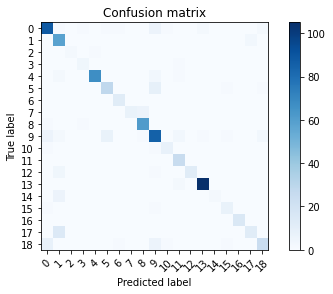

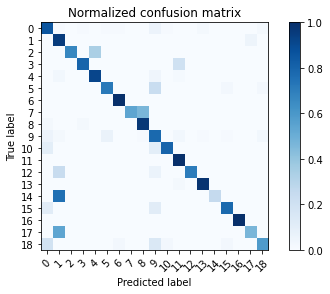

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
%matplotlib inline
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
intent = encode_text_index(df,'label')
plot_confusion_matrix(cm, intent)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, intent, title='Normalized confusion matrix')

plt.show()

## Manual Testing:

In [32]:
import string 
b = input()
b= b.lower()
a=np.array([b])
res = model.predict(a)
strList = ['label_address', 'label_amount', 'label_bill_period',
       'label_cin', 'label_date', 'label_description', 'label_email',
        'label_intents_OrgGST', 'label_intents_VendorGST',
       'label_none', 'label_pan', 'label_ph_no', 'label_quantity', 'label_sac',
       'label_tax_amount', 'label_tax_percent', 'label_tot_in_words',
       'label_total_amount', 'label_vendor_name']
result = zip(res[0]
             , strList)
set(result)

{(0.047037806, 'label_intents_OrgGST'),
 (0.047480114, 'label_intents_VendorGST'),
 (0.047557805, 'label_cin'),
 (0.049352825, 'label_email'),
 (0.049364306, 'label_tax_amount'),
 (0.05031041, 'label_pan'),
 (0.050622817, 'label_quantity'),
 (0.051090218, 'label_bill_period'),
 (0.051244862, 'label_ph_no'),
 (0.051266406, 'label_sac'),
 (0.051505674, 'label_date'),
 (0.052163824, 'label_tot_in_words'),
 (0.054223053, 'label_vendor_name'),
 (0.054266155, 'label_total_amount'),
 (0.054552518, 'label_amount'),
 (0.05477128, 'label_tax_percent'),
 (0.057891723, 'label_address'),
 (0.06102875, 'label_description'),
 (0.06426945, 'label_none')}

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       103
           1       0.67      0.95      0.78        61
           2       1.00      0.67      0.80         3
           3       0.67      0.80      0.73         5
           4       0.99      0.92      0.95        73
           5       0.78      0.72      0.75        39
           6       0.86      1.00      0.92        12
           7       1.00      0.54      0.70        13
           8       0.90      0.97      0.93        63
           9       0.76      0.78      0.77       109
          10       0.80      0.80      0.80        10
          11       0.78      1.00      0.88        25
          12       1.00      0.71      0.83        17
          13       0.97      0.98      0.98       107
          14       1.00      0.25      0.40         8
          15       0.70      0.78      0.74         9
          16       1.00      1.00      1.00        15
          17       0.80    

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>